In [1]:
import torch
import numpy as np
import os, sys, glob
import matplotlib.pyplot as plt
import PIL.Image as Image
import scipy.io as io 
import copy

sys.path.insert(0, "/home/cfoley_waller/defocam/SpectralDefocusCam")
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"

import train
import utils.helper_functions as helper
import utils.diffuser_utils as diffuser_utils
import dataset.precomp_dataset as ds
import models.forward as forward
from dataset.precomp_dataset import Normalize

%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
def detach_and_norm(pred):
    """utility to prepare predictions for visualization"""
    pred_np = pred[0].detach().cpu().numpy().transpose(1,2,0)
    pred_np = np.round(255 * ((pred_np - np.min(pred_np, axis=2)[...,None]) / np.max(pred_np - np.min(pred_np, axis=2)[...,None])))
    return pred_np

In [3]:
# load in trained model and config
config_path = "/home/cfoley_waller/defocam/defocuscamdata/models/checkpoint_train_11_21_2023_lri_precomputed_real_psfs.yml/2024_01_10_13_15_08/training_config.yml"
trained_weights_path = "/home/cfoley_waller/defocam/defocuscamdata/models/checkpoint_train_11_21_2023_lri_precomputed_real_psfs.yml/2024_01_10_13_15_08/saved_model_ep333_testloss_0.0948041341336513.pt"

# Define models for baseline: learned
config = helper.read_config(config_path)

config["data_precomputed"] = False
config["forward_model_params"]["operations"]["sim_meas"] = True

config["preload_weights"] = True
config["checkpoint_dir"] = trained_weights_path

config["device"] = "cuda:0"
device = torch.device(config["device"])
print(torch.cuda.get_device_name(device))

NVIDIA TITAN Xp


In [22]:
# Define models for baseline: fista
psf_path_rel = "/home/cfoley_waller/defocam/defocuscamdata/calibration_data/DMM_37UX178_ML_calib_data/11_21/singlepos/psfs_ONAXIS_telecent25um"
test_meas_path_rel = "/home/cfoley_waller/defocam/defocuscamdata/calibration_data/DMM_37UX178_ML_calib_data/11_21/exp_meas/duckincar"
calib_mat_path_rel = config["mask_dir"]

#exp params
sim_blur = True
w_init = [0.003, 0.018, 0.04, 0.06, 0.095]
crop_center = [1000, 2000]
crop_size = [768, 768]
patch_size = [256, 256]
ksizes = [7, 21, 45, 55, 65]
exposures = [1 / 662, 1 / 110, 1 / 45, 1 / 30, 1 / 21]
num_ims = len(exposures)

stack_depth=5
blurstride=1

fista_config = {
    "device": device,
    "mask_dir": config["mask_dir"],
    "psf_dir": psf_path_rel,
    "data_precomputed": False,
    "forward_model_params": {
        "stack_depth": stack_depth,
        "psf": {
            "lri": False,
            "stride": blurstride,
            "symmetric": True,
            "optimize": False,
            "padded_shape": crop_size[0],
            "exposures": exposures[:stack_depth*blurstride:blurstride],
            "w_init": w_init,
        },
        "operations": {
            "sim_blur": False,
            "sim_meas": True,
            "adjoint": False,
            "spectral_pad": False,
            "roll": True
        }
    },
    "recon_model_params": {
        "model_name": "fista",
        "iters": 500,
        "prox_method": 'tv',
        "tau": 0.05,
        "tv_lambda": 0.003,
        "tv_lambdaw": 0.003,
        "lowrank_lambda": 0.000005,
        "print_every": 50
    },
    "batch_size": 1,
    "patch_size": patch_size,
    "patch_crop": crop_size,
    "image_center": crop_center,
    "loss_function": {
        "name": "mse",
        "params": {
        }
    }
}

In [23]:
# Select and initialize a model
use_fista = True
if use_fista:
    cfg = fista_config
else:
    cfg = config
    
model = train.get_model(config=cfg, device=config["device"])
model.eval()

forward_model = model.model1
recon_model = model.model2

Reading psf: 100%|██████████| 5/5 [00:00<00:00, 59.42it/s]


Scaled psfs by values: [1.0, 0.1661631419939577, 0.06797583081570997, 0.045317220543806644, 0.03172205438066465]
device =  None , using GPU and cupy
<class 'cupy.core.core.ndarray'> <class 'cupy.core.core.ndarray'>


In [24]:
base_data_path_old = "/home/cfoley_waller/10tb_extension/defocam/defocuscamdata/sample_data_preprocessed/sample_data_preprocessed_lri_11_22"
base_data_path_new = "/home/cfoley_waller/defocam/defocuscamdata/sample_data_preprocessed_lri_1_22"

train_loader, val_loader, test_loader = ds.get_data_precomputed(
    config["batch_size"],
    config["data_partition"],
    base_data_path_new,
    config["num_workers"],
    config["forward_model_params"],
    shuffle=False,
    norm_target=False
)
gt = val_loader.dataset[4]['image']
sim_meas = val_loader.dataset[4]['input']

# show baseline output
# fig, ax = plt.subplots(1, len(sim_meas), figsize = (4*len(sim_meas), 4))
# fig.set_dpi(180)
# for i,meas in enumerate(sim_meas.cpu().numpy()):
#     ax[i].imshow(np.mean(meas, 0), cmap='gray')
#     ax[i].set_title(f"Focus level: {i}")
# plt.suptitle("Precomputed LRI adjoints")
# plt.show()

Prediction from precomputed data serves as our baseline: simulation with no artifacts

In [14]:
prediction = recon_model(sim_meas.unsqueeze(0).to(device))

helper.plot_cube_interactive(detach_and_norm(prediction), fc_range=[420, 720])

AssertionError: Only accepts meas stack, or batch of stacks

Prediction from the unaltered simulation forward model also serves as our baseline: simulation with no artifacts

NOTE: This is the same forward model that was used to generate the precomputed data, so this makes sense

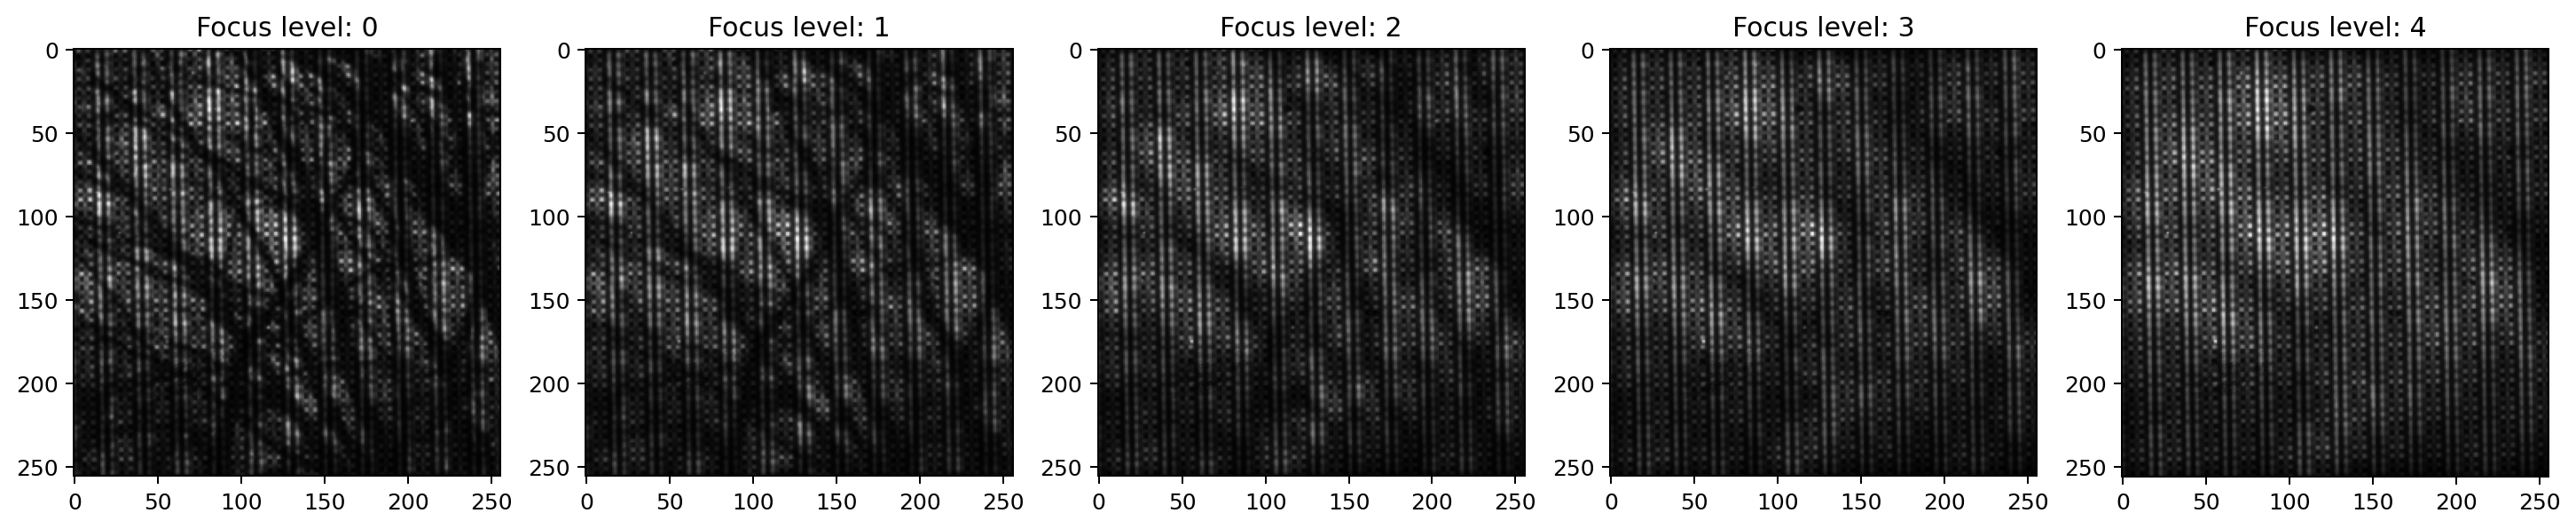

In [25]:
# First show that forward model without changes produces no artifacts
sim_meas_fwd = Normalize(0,1)(forward_model(gt.unsqueeze(0).unsqueeze(0).to(device))[0])

fig, ax = plt.subplots(1, len(sim_meas_fwd), figsize = (4*len(sim_meas_fwd), 4))
fig.set_dpi(180)
for i,meas in enumerate(sim_meas_fwd.cpu().numpy()):
    ax[i].imshow(np.mean(meas, 0), cmap='gray')
    ax[i].set_title(f"Focus level: {i}")
plt.show()

Prediction from altered forward model DOES produce artifacts

Note: The standard sample datapath into the trained model (with a precomputed dataset) is:
 - input: preprocess -> pass through forward -> normalize ->*(comes out of dataloader)* pass through recon 
 - target: preprocess -> normalize ->*(comes out of dataloader)* compare for autoencoder loss

Because of this, even though we disabled target normalization in the dataloader, we need to re-apply normalization below *after* passing the sample through our forward model.

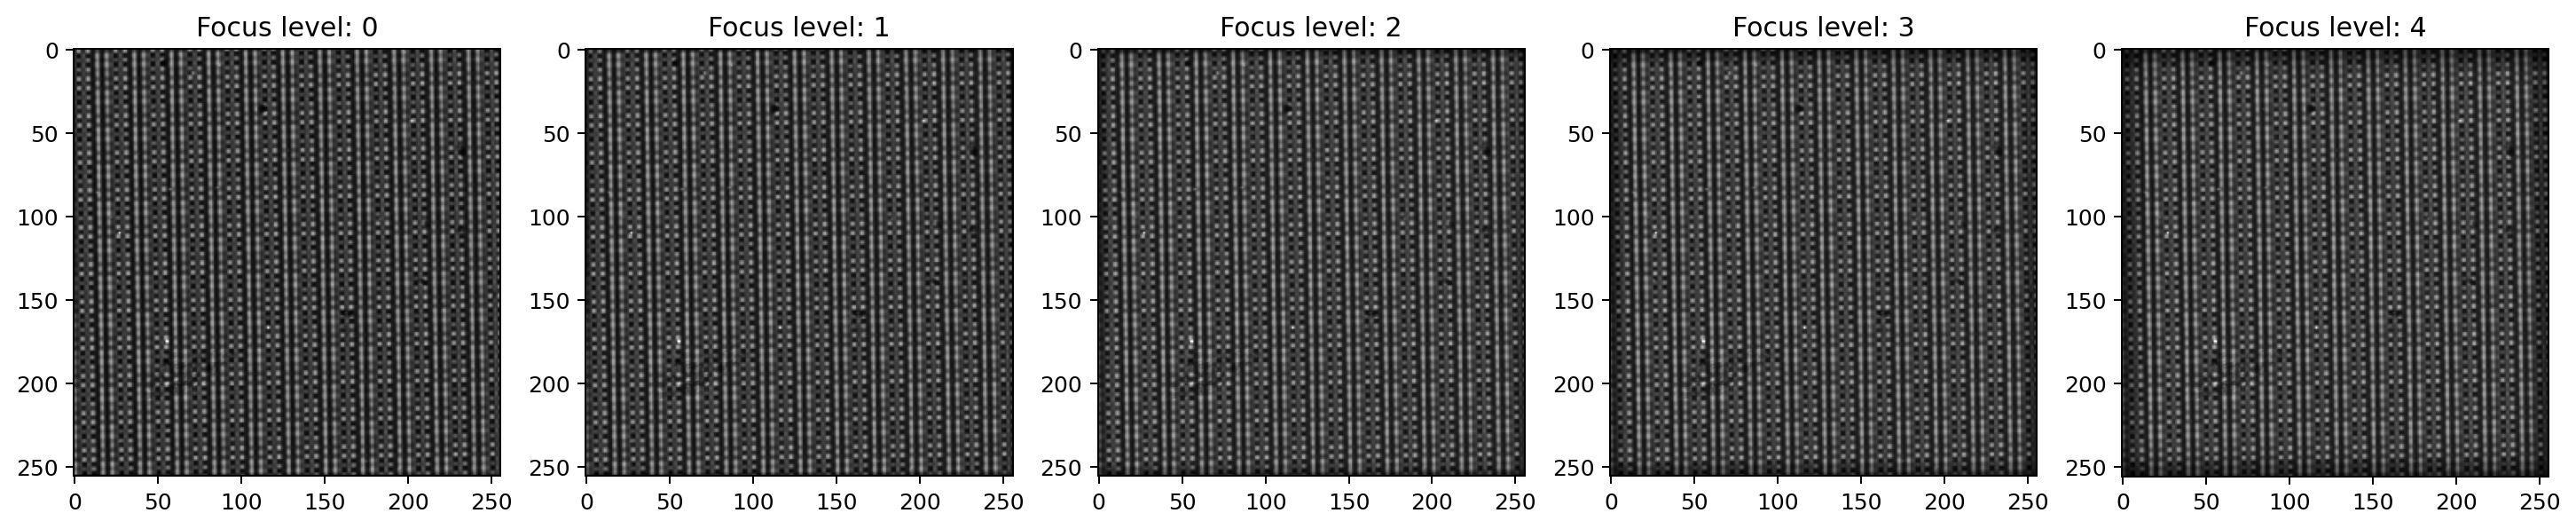

AssertionError: Only accepts meas stack, or batch of stacks

In [8]:
sim_meas_fwd_ones = Normalize(0,1)(forward_model((torch.ones_like(gt)).unsqueeze(0).unsqueeze(0).to(device))[0])

fig, ax = plt.subplots(1, len(sim_meas_fwd_ones), figsize = (4*len(sim_meas_fwd_ones), 4))
fig.set_dpi(180)
for i,meas in enumerate(sim_meas_fwd_ones.cpu().numpy()):
    ax[i].imshow(np.mean(meas, 0), cmap='gray')
    ax[i].set_title(f"Focus level: {i}")
plt.show()

prediction_ones_bias = recon_model(sim_meas_fwd_ones.unsqueeze(0).to(device))

helper.plot_cube_interactive(detach_and_norm(prediction_ones_bias), fc_range=[420, 720])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iteration:  0  loss:  74313.74816304343


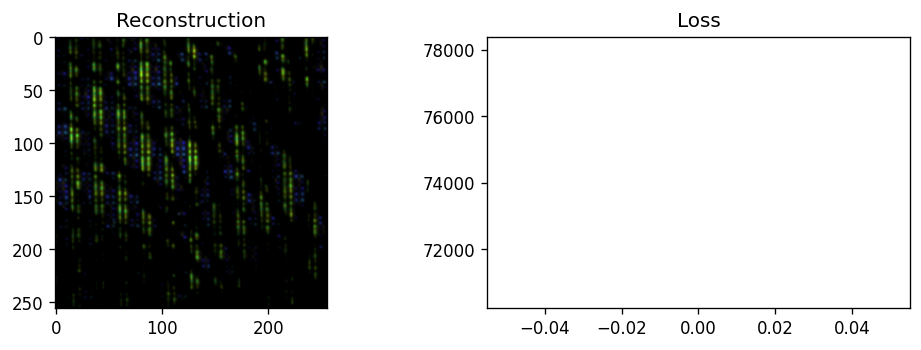

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iteration:  50  loss:  21569.38868326463


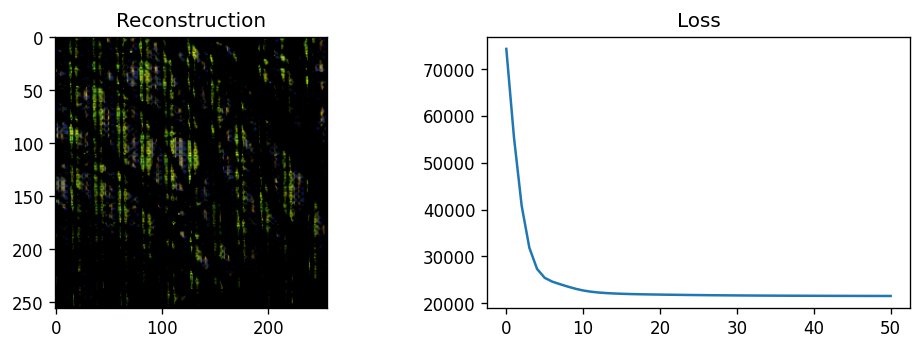

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iteration:  100  loss:  21492.257747002757


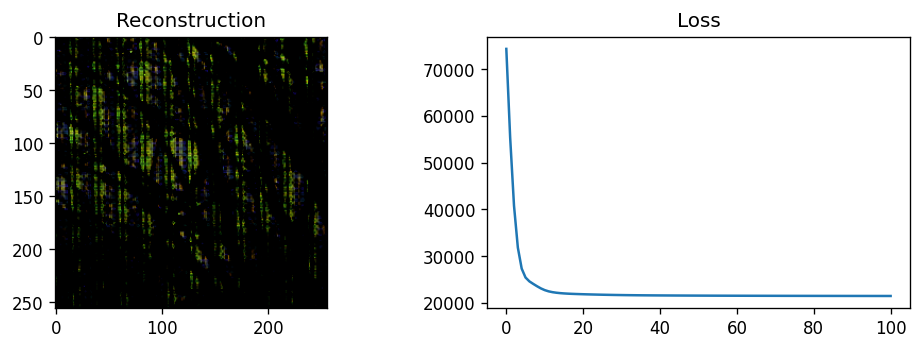

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


iteration:  150  loss:  21464.614536988815


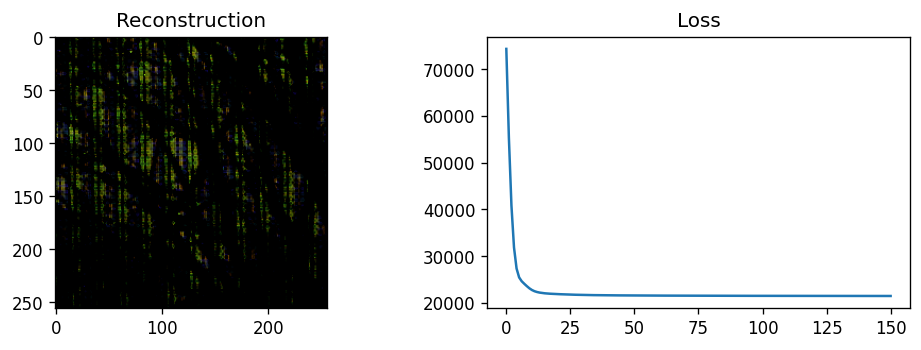

KeyboardInterrupt: 

In [26]:
prediction_baseline = recon_model(sim_meas_fwd.to(device))

helper.plot_cube_interactive(detach_and_norm(prediction_baseline), fc_range=[420, 720])

Using a simple gaussian approximation for a model trained with experimental LRI psfs results in extreme blurring and inaccurate spectral response

In [17]:
# Then test whether we see artifacts if we use simple, inaccurate PSFs
mask = diffuser_utils.load_mask(
    path=config["mask_dir"],
    patch_crop_center=config["image_center"],
    patch_crop_size=config["patch_crop"],
    patch_size=config["patch_size"],
)

gauss_config = copy.deepcopy(config)
gauss_config["forward_model_params"]["psf"]["w_init"] = np.linspace(0.002, 0.05, 5)
gauss_config["forward_model_params"]["psf"]["lri"] = False
forward_model_gaus_blur_lsi = forward.ForwardModel(mask, gauss_config["forward_model_params"], gauss_config["psf_dir"], device=device)
forward_model_gaus_blur_lsi.operations['sim_blur'] = True
forward_model_gaus_blur_lsi.operations['roll'] = True
forward_model_gaus_blur_lsi.psf['lri'] = False

forward_model_gaus_blur_lsi.init_psfs()

# show simulation
fig, ax = plt.subplots(1, len(forward_model_gaus_blur_lsi.psfs), figsize = (4*len(forward_model_gaus_blur_lsi.psfs), 4))
fig.set_dpi(180)
for i,meas in enumerate(sim_meas_fwd.cpu().numpy()):
    ax[i].imshow(forward_model_gaus_blur_lsi.psfs[i].cpu().numpy(), cmap='inferno')
    ax[i].set_title(f"Focus level: {i}")
plt.suptitle("maximum psf should be about 75/3 = 25 pixels at FWHM")
plt.show()

sim_meas_gauss = Normalize(0,1)(forward_model_gaus_blur_lsi(gt.unsqueeze(0).unsqueeze(0).to(device))[0])

fig, ax = plt.subplots(1, len(sim_meas_gauss), figsize = (4*len(sim_meas_fwd), 4))
fig.set_dpi(180)
for i,meas in enumerate(sim_meas_gauss.cpu().numpy()):
    ax[i].imshow(np.mean(meas, 0), cmap='gray')
    ax[i].set_title(f"Focus level: {i}")
plt.show()

In [19]:
prediction_wrong_psfs = recon_model(sim_meas_gauss.unsqueeze(0).to(device))

helper.plot_cube_interactive(detach_and_norm(prediction_wrong_psfs), fc_range=[420, 720])

FigureWidget({
    'data': [{'type': 'image',
              'uid': '59f7023c-d0da-414a-a958-3de9c79cc172',
              'xaxis': 'x',
              'yaxis': 'y',
              'z': array([[[ 25,  32,  54],
                           [ 50,  63, 105],
                           [ 57,  71, 115],
                           ..., 
                           [  4,   8,   9],
                           [  4,   8,  11],
                           [  3,   5,   9]],
                   
                          [[ 51,  64, 108],
                           [ 76,  96, 158],
                           [ 78,  98, 156],
                           ..., 
                           [  5,   8,   7],
                           [  5,   9,  10],
                           [  3,   5,   8]],
                   
                          [[ 61,  77, 130],
                           [ 84, 105, 173],
                           [ 80, 101, 161],
                           ..., 
                           [ 13,  16

Using just the on-axis measured psf of our LRI system results in vertical striations, worsening as we move away from the center (as the psf approximation gets worse)

Note: these striations are more densely spaced than the ones we see in sim -> experimental recons. This is a sign that perhaps the psf is not the issue

In [39]:
# test whether we see artifacts if we use measured by LSI PSFs
psf_path = "/home/cfoley_waller/defocam/defocuscamdata/calibration_data/DMM_37UX178_ML_calib_data/11_21/singlepos/psfs_ONAXIS_telecent25um"
mask = diffuser_utils.load_mask(
    path=config["mask_dir"],
    patch_crop_center=config["image_center"],
    patch_crop_size=config["patch_crop"],
    patch_size=config["patch_size"],
)
lsi_config = copy.deepcopy(config)
lsi_config["forward_model_params"]["psf"]["lri"] = False
lsi_config["psf_dir"] = "/home/cfoley_waller/defocam/defocuscamdata/calibration_data/DMM_37UX178_ML_calib_data/11_21/singlepos/psfs_ONAXIS_telecent25um"
forward_model_lsi = forward.ForwardModel(mask, lsi_config["forward_model_params"], lsi_config["psf_dir"], device=device)
forward_model_lsi.operations['sim_blur'] = False
forward_model_lsi.operations['roll'] = True
forward_model_lsi.psf['lri'] = False

forward_model_lsi.init_psfs()

# show simulation
fig, ax = plt.subplots(1, len(forward_model_lsi.psfs), figsize = (4*len(forward_model_lsi.psfs), 4))
fig.set_dpi(180)
for i,meas in enumerate(sim_meas_fwd.cpu().numpy()):
    ax[i].imshow(forward_model_lsi.psfs[i].cpu().numpy(), cmap='inferno')
    ax[i].set_title(f"Focus level: {i}")
plt.suptitle("maximum psf should be about 75/3 = 25 pixels at FWHM")
plt.show()

sim_meas_lsi = Normalize(0,1)(forward_model_lsi(gt.unsqueeze(0).unsqueeze(0).to(device))[0])

fig, ax = plt.subplots(1, len(sim_meas_lsi), figsize = (4*len(sim_meas_lsi), 4))
fig.set_dpi(180)
for i,meas in enumerate(sim_meas_lsi.cpu().numpy()):
    ax[i].imshow(np.mean(meas, 0), cmap='gray')
    ax[i].set_title(f"Focus level: {i}")
plt.show()

Reading psf: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


Scaled psfs by values: [1.0, 0.16611661166116612, 0.06795679567956796, 0.045304530453045305, 0.03171602604494854]


In [42]:
prediction_lsi = recon_model(sim_meas_lsi.unsqueeze(0).to(device))

helper.plot_cube_interactive(detach_and_norm(prediction_lsi), fc_range=[420, 720])

FigureWidget({
    'data': [{'type': 'image',
              'uid': '2ec699e1-19f2-4b79-a4d1-62280ca22bd4',
              'xaxis': 'x',
              'yaxis': 'y',
              'z': array([[[101, 108,  11],
                           [106, 113,  10],
                           [109, 114,  11],
                           ..., 
                           [152, 141,   7],
                           [150, 140,   6],
                           [146, 136,   5]],
                   
                          [[106, 114,  11],
                           [113, 122,  11],
                           [118, 125,  14],
                           ..., 
                           [160, 149,   8],
                           [156, 147,   7],
                           [149, 140,   6]],
                   
                          [[121, 128,  10],
                           [129, 137,  10],
                           [138, 143,  12],
                           ..., 
                           [179, 171

Randomly scaling our mask to simulate an inaccurate spectral filter calibration results in miscoloration, but no artifacts, indicating that it is not the culprit

[[[ 1.14142213  1.1757318   0.69853933  0.68456849  1.14940094  0.94408298
    1.09150661  1.24415937  0.62518655  1.0317411   1.29155151  1.01377218
    0.6399128   1.04976605  1.46949615  0.6654548   1.49115842  0.63119369
    0.85740352  0.74049977  0.91674424  0.82035798  1.21649809  0.54496613
    1.35342907  1.06715466  0.74880758  1.3474924   0.70126947  1.11439079]]]


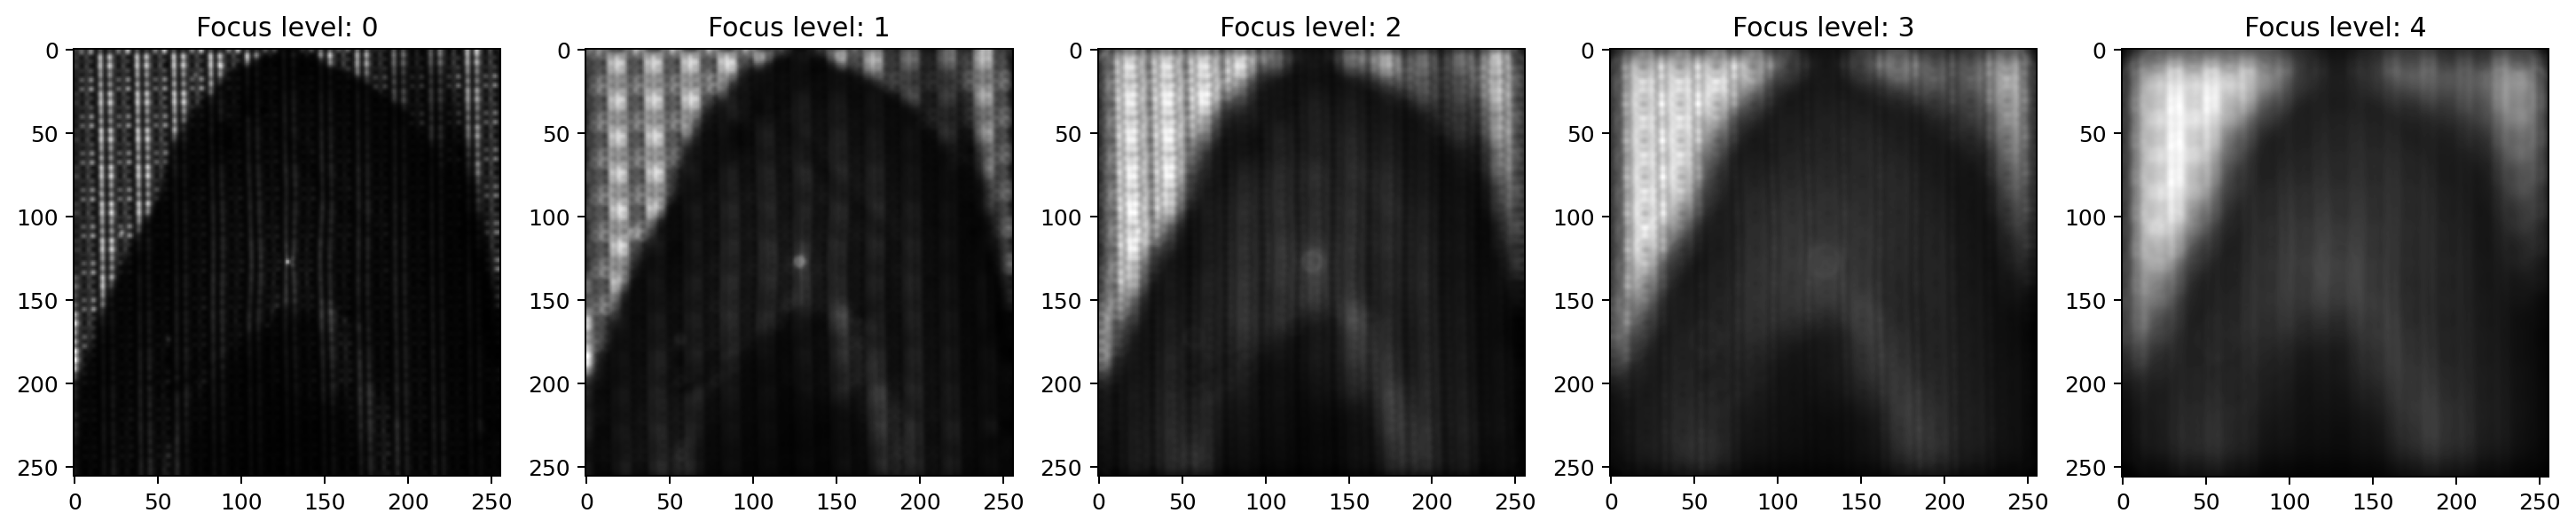

In [13]:
# test whether we see artifacts if we use a randomly scaled mask
scale_frac = 0.5
mask = diffuser_utils.load_mask(
    path=config["mask_dir"],
    patch_crop_center=config["image_center"],
    patch_crop_size=config["patch_crop"],
    patch_size=config["patch_size"],
)
scale = (np.random.rand(1,1,30) * scale_frac*2) + (1-scale_frac)
print(scale)
mask *= scale

forward_model_scaled_mask = forward.ForwardModel(mask, config["forward_model_params"], config["psf_dir"], device=device)
forward_model_scaled_mask.init_psfs()

# show simulation
sim_meas_scaled_mask = Normalize(0,1)(forward_model_scaled_mask(gt.unsqueeze(0).unsqueeze(0).to(device))[0])

fig, ax = plt.subplots(1, len(sim_meas_scaled_mask), figsize = (4*len(sim_meas_scaled_mask), 4))
fig.set_dpi(180)
for i,meas in enumerate(sim_meas_scaled_mask.cpu().numpy()):
    ax[i].imshow(np.mean(meas, 0), cmap='gray')
    ax[i].set_title(f"Focus level: {i}")
plt.show()

In [15]:
prediction_scaled_mask = recon_model(sim_meas_scaled_mask.unsqueeze(0).to(device))

helper.plot_cube_interactive(detach_and_norm(prediction_scaled_mask), fc_range=[420, 720])

FigureWidget({
    'data': [{'type': 'image',
              'uid': '0a8cb2cf-ff97-4670-9ce9-40165ba36c49',
              'xaxis': 'x',
              'yaxis': 'y',
              'z': array([[[ 96, 105,  33],
                           [104, 114,  36],
                           [108, 120,  43],
                           ..., 
                           [127, 146,  48],
                           [115, 131,  40],
                           [110, 126,  36]],
                   
                          [[105, 115,  38],
                           [117, 128,  48],
                           [122, 134,  55],
                           ..., 
                           [135, 154,  56],
                           [122, 138,  46],
                           [115, 130,  41]],
                   
                          [[111, 123,  46],
                           [126, 138,  58],
                           [133, 147,  63],
                           ..., 
                           [135, 152

Randomly shifting/warping our mask to simulate a nonlinear assumption calibration results in bad-color/blocky reconstruction, with small block-wise artifacts along both dimensions

/home/cfoley_waller/anaconda3/envs/SpectralDiffuserCam/lib/python3.9/site-packages/torch/functional.py:504: UserWarning:

torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)



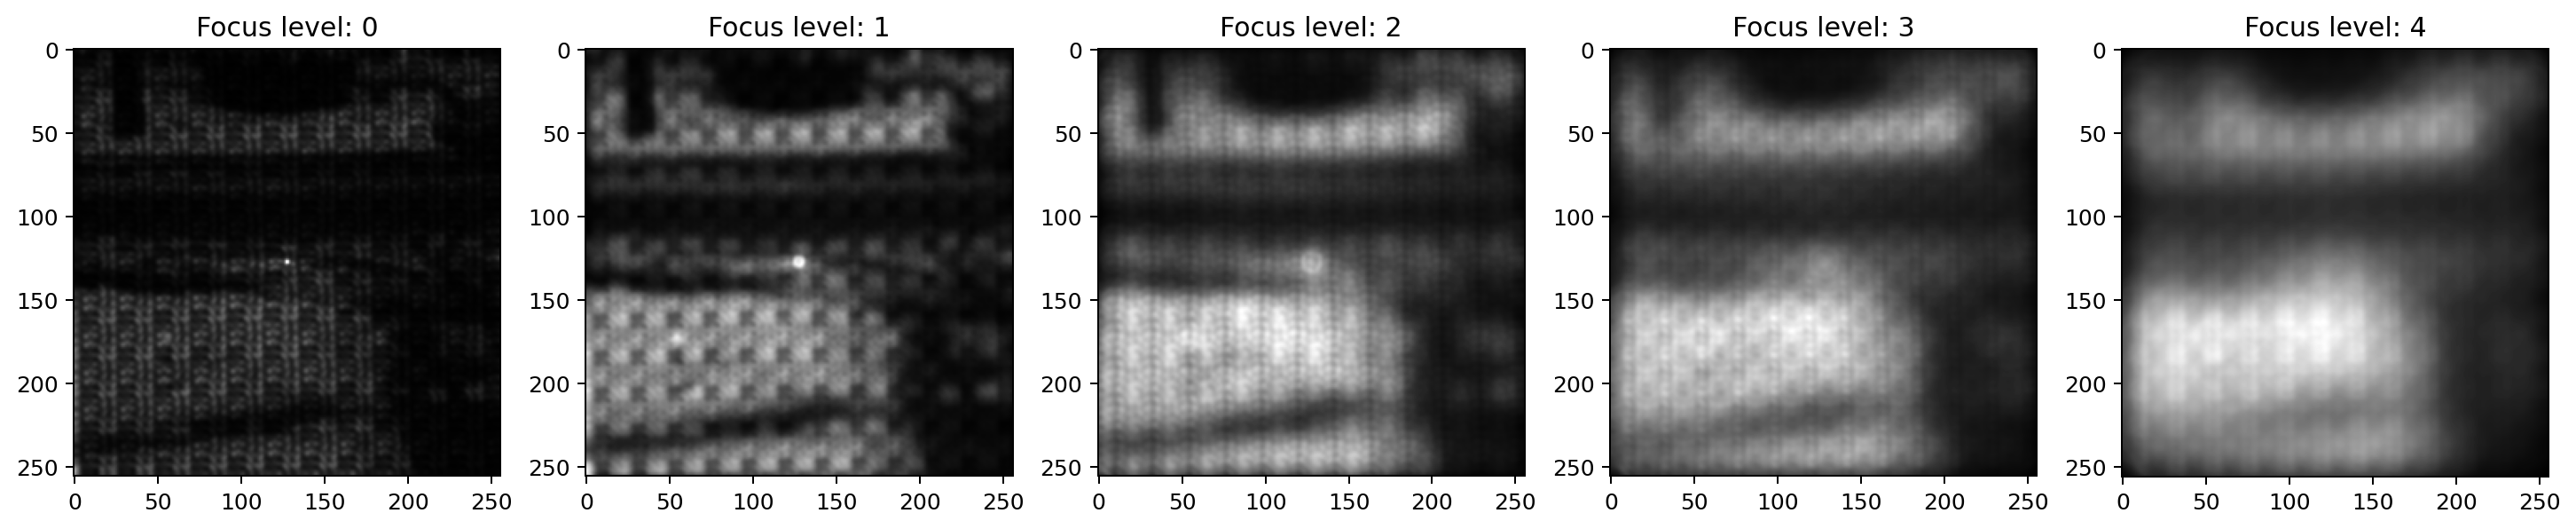

In [7]:
# test whether we see artifacts if we use a randomly scaled mask
def random_shift_with_padding(mask, shift_n = 2):
    from scipy.ndimage import shift
    shifted_mask = np.zeros_like(mask)
    for i in range(mask.shape[2]):
        shift_x = np.random.randint(-shift_n, shift_n)
        shift_y = np.random.randint(-shift_n, shift_n)

        # Pad the slice to prevent loss of information when shifting
        padded_slice = np.pad(mask[:, :, i], shift_n, mode='edge')
        shifted_slice = shift(padded_slice, shift=[shift_x, shift_y])
        shifted_mask[:, :, i] = shifted_slice[shift_n:-shift_n, shift_n:-shift_n]
    return shifted_mask

mask = diffuser_utils.load_mask(
    path=config["mask_dir"],
    patch_crop_center=config["image_center"],
    patch_crop_size=config["patch_crop"],
    patch_size=config["patch_size"],
)
mask = random_shift_with_padding(mask)

forward_model_shift_mask = forward.ForwardModel(mask, config["forward_model_params"], config["psf_dir"], device=device)
forward_model_shift_mask.init_psfs()

# show simulation
sim_meas_shift_mask= Normalize(0,1)(forward_model_shift_mask(gt.unsqueeze(0).unsqueeze(0).to(device))[0])

fig, ax = plt.subplots(1, len(sim_meas_shift_mask), figsize = (4*len(sim_meas_shift_mask), 4))
fig.set_dpi(180)
for i,meas in enumerate(sim_meas_shift_mask.cpu().numpy()):
    ax[i].imshow(np.mean(meas, 0), cmap='gray')
    ax[i].set_title(f"Focus level: {i}")
plt.show()

In [8]:
prediction_shift_mask = recon_model(sim_meas_shift_mask.unsqueeze(0).to(device))

helper.plot_cube_interactive(detach_and_norm(prediction_shift_mask), fc_range=[420, 720])

FigureWidget({
    'data': [{'type': 'image',
              'uid': 'd42d7131-da44-4195-8b06-1e9ca85bdc38',
              'xaxis': 'x',
              'yaxis': 'y',
              'z': array([[[  1,   0,   7],
                           [  2,   0,  12],
                           [  4,   3,  14],
                           ..., 
                           [ 15,   6,  25],
                           [ 12,   5,  26],
                           [  8,   3,  19]],
                   
                          [[  3,   0,  12],
                           [  3,   1,  17],
                           [  5,   4,  18],
                           ..., 
                           [ 19,   7,  32],
                           [ 16,   6,  34],
                           [ 10,   4,  24]],
                   
                          [[  4,   1,  15],
                           [  5,   2,  19],
                           [  4,   1,  16],
                           ..., 
                           [ 19,   8

test space for no adjoint


In [12]:
mask = diffuser_utils.load_mask(
    path=config["mask_dir"],
    patch_crop_center=config["image_center"],
    patch_crop_size=config["patch_crop"],
    patch_size=config["patch_size"],
)

forward_model_no_adj = forward.ForwardModel(mask, config["forward_model_params"], config["psf_dir"], device=device)
forward_model_no_adj.operations["adjoint"] = False
forward_model_no_adj.operations["spectral_pad"] = False
forward_model_no_adj.init_psfs()

# show simulation
sim_meas_no_adj= Normalize(0,1)(forward_model_no_adj(gt.unsqueeze(0).unsqueeze(0).to(device))[0])

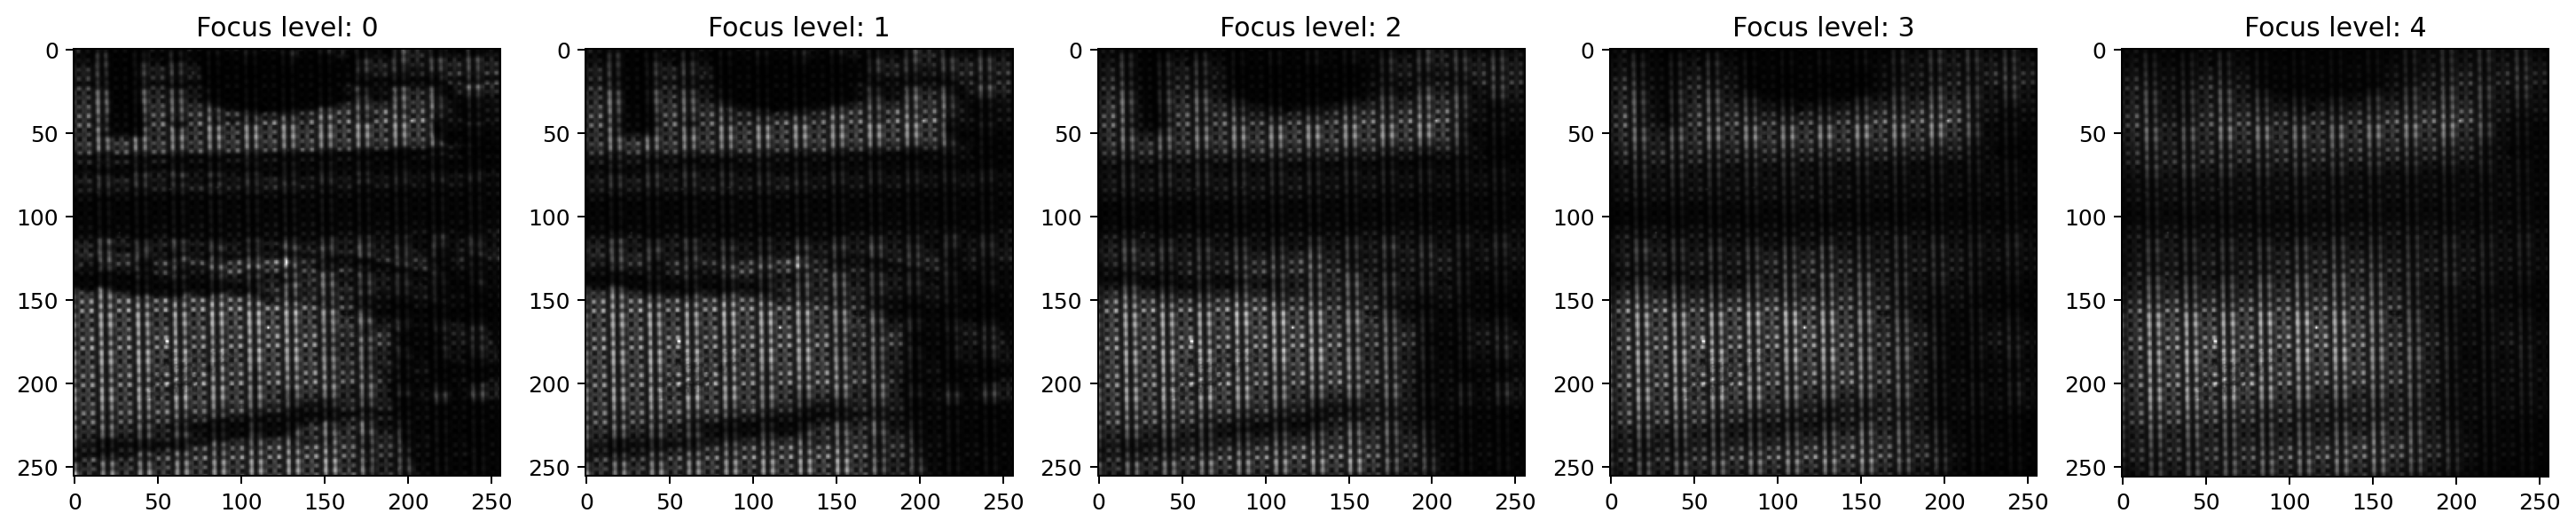

: 

In [15]:

fig, ax = plt.subplots(1, len(sim_meas_no_adj), figsize = (4*len(sim_meas_no_adj), 4))
fig.set_dpi(180)
for i,meas in enumerate(sim_meas_no_adj.cpu().numpy()):
    ax[i].imshow(meas[0], cmap='gray')
    ax[i].set_title(f"Focus level: {i}")
plt.show()